<a href="https://colab.research.google.com/github/ContiPaolo/EKF-SINDy/blob/main/SelkovModel_OnlineLearning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
###########################  CLONE EKF-SINDY AND INSTALL PACKAGES  ###########################
from IPython.display import clear_output
import sys
sys.path.append('/content/EKF-SINDy')
!git clone https://github.com/ContiPaolo/EKF-SINDy
!pip install pysindy pyDOE filterpy
clear_output()
print("EKF-SINDy ready to go :)")

###########################                LIBRARIES                ###########################
import numpy as np
import pysindy as ps
from scipy.integrate import odeint
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from pyDOE import lhs
import copy
import sympy as sp

from utils_EKFSINDy import add_noise_with_snr
seed = 1

EKF-SINDy ready to go :)


# Selkov Model

The Selkov model equations are:

\begin{aligned}
\quad u_1' &= \rho - \sigma_1 \cdot u_1 - b_{122,1} \cdot u_1 \cdot u_2^2, \\
\quad u_2' &= -k_{2,2} \cdot u_2 + \sigma_2 \cdot u_1 + b_{122,2} \cdot u_1 \cdot u_2^2.
\end{aligned}


The equilibrium point is:

$(x_0, y_0) = \left(\frac{\rho}{\sigma + \rho^2}, \rho\right)$

### Hopf Bifurcations and Stability Regions

By varying $\rho$, two Hopf bifurcations occur, defining three regions of stability:

- $\rho < 0.41$: Stable fixed point.
- $0.41 < \rho < 0.8$: Stable limit cycle.
- $\rho > 0.8$: Stable fixed point.

The bifurcation values of $\rho$ are:
- $\rho_1 = 0.41$
- $\rho_2 = 0.8$

In [2]:
# Define parameters for Sel'kov model for the offline training
system = {
    'sigma'  : 0.10,
    'rho'    : 0.92,
    't0'     : 0.00,
    'T_train': 100.,
    'dt'     : 0.10
}

# Define the differential equations for the Sel'kov model
def f(y, t, system = system, train = True):
    u1, u2 = y
    sigma  = system['sigma']

    if train:
      #during training we consider a constant value of rho
      rho = system['rho']
    else:
      #during testing we vary rho (from rho_start to rho_end)
      rho_start, rho_end, T, T1, T_sweep  = system['rho_start'], system['rho_end'], system['T'], system['T1'], system['T_sweep']
      if t < T1:
          rho = rho_start
      elif t > T1+T_sweep:
          rho = rho_end
      else:
          rho = rho_start + (rho_end-rho_start)*(t-T1)/T_sweep

    #Selk'ov model:
    du1 = rho - sigma * u1 - u1 * u2**2
    du2 = -u2 + sigma * u1 + u1 * u2**2

    return [du1, du2]

In [3]:
# %%
######################       GENERATE DATA       ######################

t_train = np.arange(system['t0'], system['T_train'], system['dt'])

#Generate random ICs
np.random.seed(seed=seed)
u1_0 = np.random.normal(0.2, 2, 20)
u2_0 = np.random.normal(0.2, 2, 20)

#number of instances
n_train = 16

#Generate data
Xtrain = []

for i in range(n_train):
    y0 = [u1_0[i], u2_0[i]]
    sol = odeint(f, y0, t_train, args=(system, True))
    Xtrain.append(sol)

#%%
# ######################      CREATE SINDy model       ######################
# We use SINDy to identify a model for the Sel'kov dynamics.
model = ps.SINDy(feature_names=['u1', 'u2'],
                 feature_library=ps.PolynomialLibrary(degree=3),
                 optimizer=ps.STLSQ(threshold=5e-2))
model.fit(Xtrain, t=system['dt'], multiple_trajectories=True)
model.print()

#store model coefficients
coeffs = model.coefficients()

(u1)' = 0.923 1 + -0.094 u1 + -0.076 u1 u2 + -0.929 u1 u2^2
(u2)' = 0.108 u1 + -0.934 u2 + 0.918 u1 u2^2


In [4]:
#%% Parameters for the identification of the SINDy model
system = {
    'sigma'    : 0.10,
    #in the identification phase we will change the parameter rho from rho_start to rho_end
    'rho_start': 0.92,
    'rho_end'  : 0.70,

    't0'       : 0.0,
    'T1'       : 50.,  #time instance for which the change of parameter occurs
    'T_sweep'  : 50.,  #length of the time window for which the parameter changes linearly
    'T'        : 300., #final time
    #note that we online assimilation is up to T=300, which is much longer than the training time T_train=100
    'dt'       : 0.10
}

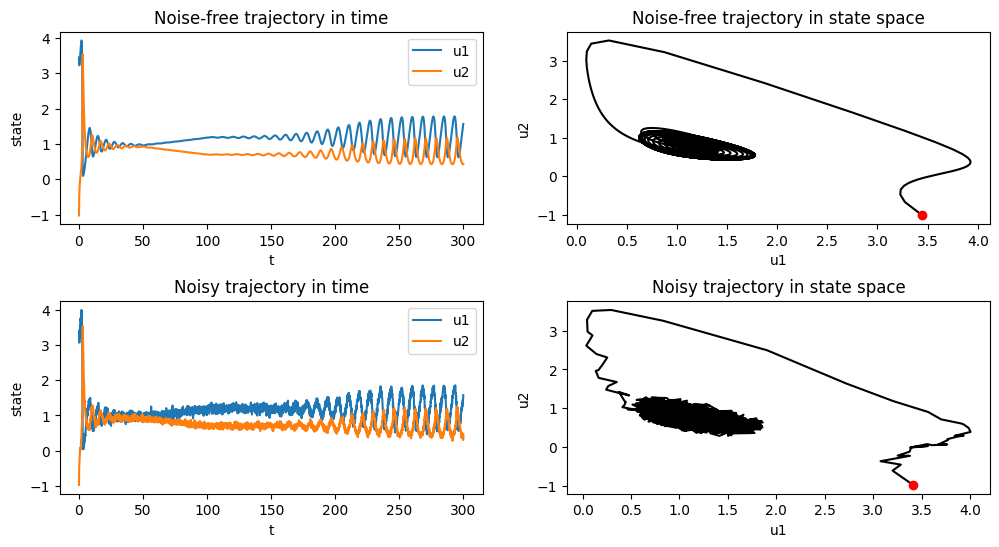

In [5]:
# %%
######################       GENERATE DATA for EKF       ######################
#Number of instances
n_test = 1

# Define the time frame
t0, T1, T, T_sweep, dt = system['t0'], system['T1'], system['T'], system['T_sweep'], system['dt']
t = np.arange(t0,T,dt)
Nt = len(t)

#Generate random ICs
np.random.seed(seed=seed)
u1_0 = np.random.normal(0.2,2,n_test)
u2_0 = np.random.normal(0.2,2,n_test)

#Generate data
y0 = np.array([u1_0[0],u2_0[0]])
X  = odeint(f,y0,t, args=(system, False))

#Plot test data
plt.figure(figsize = [12,6])
plt.subplot(2,2,1)
plt.plot(t,X[:,0],label='u1')
plt.plot(t,X[:,1],label='u2')
plt.xlabel('t')
plt.ylabel('state')
plt.title('Noise-free trajectory in time')
plt.legend()

plt.subplot(2,2,2)
plt.plot(X[:,0],X[:,1],'black')
plt.plot(u1_0[0],u2_0[0],'ro')
plt.xlabel('u1')
plt.ylabel('u2')
plt.title('Noise-free trajectory in state space')

#Add noise:
X[:,0]      = add_noise_with_snr(X[:,0],25)
X[:,1]      = add_noise_with_snr(X[:,1],25)

plt.subplot(2,2,3)
plt.plot(t,X[:,0],label='u1')
plt.plot(t,X[:,1],label='u2')
plt.xlabel('t')
plt.ylabel('state')
plt.title('Noisy trajectory in time')
plt.legend()

plt.subplot(2,2,4)
plt.plot(X[:,0],X[:,1],'black')
plt.plot(X[0,0],X[0,1],'ro')
plt.xlabel('u1')
plt.ylabel('u2')
plt.title('Noisy trajectory in state space')

plt.subplots_adjust(hspace=0.4)
plt.show()

In [6]:
sindy_library_names = model.get_feature_names()

# Define symbolic variables
u1, u2 = sp.symbols('u1 u2')

# Convert feature names to symbolic expressions
terms = []
for term in sindy_library_names:
    # Replace '^' with '**' for exponentiation in SymPy and remove any spaces
    term = term.replace('^', '**').replace(' ', '*')
    try:
        terms.append(eval(term, {'u1': u1, 'u2': u2}))
    except SyntaxError as e:
        print(f"Error parsing term '{term}': {e}")

# Set up SINDy library terms and their derivatives
sindy_library = [sp.lambdify((u1, u2), expr) for expr in terms]
print("SINDy library terms:")
for expr in terms:
    print(expr)

sindy_library_du1 = [sp.lambdify((u1, u2), sp.diff(expr, u1)) for expr in terms]
print("\nDerivatives with respect to u1:")
for expr in terms:
    print(sp.diff(expr, u1))

sindy_library_du2 = [sp.lambdify((u1, u2), sp.diff(expr, u2)) for expr in terms]
print("\nDerivatives with respect to u2:")
for expr in terms:
    print(sp.diff(expr, u2))

SINDy library terms:
1
u1
u2
u1**2
u1*u2
u2**2
u1**3
u1**2*u2
u1*u2**2
u2**3

Derivatives with respect to u1:
0
1
0
2*u1
u2
0
3*u1**2
2*u1*u2
u2**2
0

Derivatives with respect to u2:
0
0
1
0
u1
2*u2
0
u1**2
2*u1*u2
3*u2**2


In [7]:
def extract_coefficients(coeffs, selected_entries, equation_indices, multiplier):
    """
    Extracts non-zero coefficients and associated SINDy library terms for specific equations.

    Parameters:
    - coeffs: numpy.ndarray, the coefficients identified by SINDy.
    - selected_entries: list, indices of coefficients to extract.
    - equation_indices: numpy.ndarray, array indicating which equations the coefficients belong to.
    - multiplier: int, coefficient multiplier (reserved for advanced cases).

    Returns:
    - B_map: numpy.ndarray, mapping of coefficients to terms.
    - unique_terms: numpy.ndarray, unique indices of SINDy library terms.
    - sindy_terms_per_eq: list, symbolic SINDy terms for each equation.
    - sindy_term_names_per_eq: list, names of terms for each equation.
    - coeff_matrix: numpy.ndarray, coefficient matrix for the extracted terms.
    - sindy_derivatives_u1: list, derivatives of SINDy terms w.r.t. u1.
    - sindy_derivatives_u2: list, derivatives of SINDy terms w.r.t. u2.
    """
    non_zero_indices_all = np.nonzero(coeffs)
    non_zero_indices = (
        non_zero_indices_all[0][selected_entries],
        non_zero_indices_all[1][selected_entries],
    )
    unique_terms = np.unique(non_zero_indices[1])

    term_offset = 0
    B_map = []
    coeff_matrix = []
    sindy_terms_per_eq = []
    sindy_term_names_per_eq = []
    sindy_derivatives_u1 = []
    sindy_derivatives_u2 = []

    if len(unique_terms) > 0:
        B_map = np.zeros((coeffs.shape[0], coeffs.shape[1], len(unique_terms)))
        coeff_matrix = np.zeros((coeffs.shape[0], len(unique_terms)))

        for eq_idx in range(n_eqs):
            # Extract indices and terms specific to the current equation
            current_eq_indices = np.array(np.where(eq_idx == equation_indices))
            eq_terms = non_zero_indices[1][current_eq_indices[0]]

            eq_sindy_terms = []
            eq_term_names = []
            eq_derivative_u1 = []
            eq_derivative_u2 = []

            for term_idx in range(len(current_eq_indices[0])):
                # Map coefficients and library terms
                B_map[eq_idx, eq_terms[term_idx], term_idx] = 1.0
                global_term_idx = term_idx + term_offset

                eq_sindy_terms.append(sindy_library[eq_terms[term_idx]])
                eq_term_names.append(sindy_library_names[eq_terms[term_idx]])
                eq_derivative_u1.append(sindy_library_du1[eq_terms[term_idx]])
                eq_derivative_u2.append(sindy_library_du2[eq_terms[term_idx]])

            if eq_idx > 0:
                sindy_terms_per_eq.append(eq_sindy_terms)
                sindy_term_names_per_eq.append(eq_term_names)
                sindy_derivatives_u1.append(eq_derivative_u1)
                sindy_derivatives_u2.append(eq_derivative_u2)
            else:
                sindy_terms_per_eq = [eq_sindy_terms]
                sindy_term_names_per_eq = [eq_term_names]
                sindy_derivatives_u1 = [eq_derivative_u1]
                sindy_derivatives_u2 = [eq_derivative_u2]

            term_offset += len(current_eq_indices[0])
            coeff_matrix[eq_idx, :] = coeffs[eq_idx, :] @ B_map[eq_idx, :, :]

    return (
        B_map,
        unique_terms,
        sindy_terms_per_eq,
        sindy_term_names_per_eq,
        coeff_matrix,
        sindy_derivatives_u1,
        sindy_derivatives_u2,
    )

In [8]:
#%% Initialize the SINDy-EKF setup

n_eqs = 2  # Number of equations (states)
non_zero_coeff_indices = np.nonzero(coeffs)

N_x    = 2 #termini di stato
N_obs  = 2
N_xu   = 2

coeff_names     = ['rho','sigma_1','a12_1', 'b122_1','sigma_2','k2_2', 'b122_2']
funct_names     = [  '1',     'u1','u1*u2','u1*u2^2',     'u1',  'u2','u1*u2^2']
true_coeff      = [system['rho_start'],-1*system['sigma'],0.0,-1.0,system['sigma'],-1.0,1.0]

eqOfInterest   = np.array([0,0,0,0,1,1,1])
keepEntries    = [0,1,2,3,4,5,6]                      #scritte rispetto a nonZeroCoeff
eqOfInterestOut= np.array([])
takeOutEntries = []
multEntries    = 1

N_param = len(keepEntries)

# Map the SINDy coefficients
(
    B_map,
    unique_terms,
    sindy_terms,
    term_names,
    A,
    sindy_derivatives_u1,
    sindy_derivatives_u2,
) = extract_coefficients(coeffs, keepEntries, eqOfInterest, multEntries)

(
    B_map_out,
    unique_terms_out,
    sindy_terms_out,
    term_names_out,
    A_out,
    sindy_derivatives_u1_out,
    sindy_derivatives_u2_out,
) = extract_coefficients(coeffs, takeOutEntries, eqOfInterestOut, multEntries)

# Observations and parameters setup
h_coeffs     = np.zeros(shape=(N_obs,A.shape[1]))
h_coeffs[0,1] = 1.0  #[0,1,4,8] --> u1
h_coeffs[1,1] = 1.0  #[1,2,8]   --> u2
h_coeffs_out = np.zeros(shape=(N_obs,len(unique_terms)))

In [9]:
# %% define the transition model (coincides with the observation model)
def model_Asindy(A, dyn_state, t_, sindy_terms):
    '''
    A: matrix of SINDy coefficients for the states and parameters (transition equation)
    dyn_state: [u1, u2]
    '''
    u1, u2 = dyn_state

    # Initialize the derivative of the dynamic state
    dyn_state_t_ = np.zeros(dyn_state.shape)

    # If SINDy terms are provided, evaluate them
    if sindy_terms:  # if not empty
        sindy_terms_eval = np.zeros(shape=(A.shape[1]))
        for eq_idx in np.arange(len(sindy_terms)):
            for term_idx in np.arange(len(sindy_terms[eq_idx])):
                sindy_terms_eval[term_idx] = sindy_terms[eq_idx][term_idx](u1, u2)
            # Update the dynamic state derivative
            dyn_state_t_[eq_idx] = A[eq_idx][:] @ sindy_terms_eval

    return dyn_state_t_

# %% update the transition model
def updateA(A, param_state):
    param_offset = 0
    # Iterate through each equation
    for eq_idx in np.arange(n_eqs):
        eq_indices = np.array(np.where(eq_idx == eqOfInterest))
        # Update coefficients for each term in the equation
        for term_idx in np.arange(len(eq_indices[0])):
            A[eq_idx, term_idx] = param_state[term_idx + param_offset]
        if eq_idx == 0:
            param_offset += 1
        param_offset += term_idx

    return A

# %% compute the Jacobian of the SINDy library
def compute_J_library(sindy_terms, dyn_state, t_, n_features, sindy_derivatives_u1, sindy_derivatives_u2):
    u1, u2 = dyn_state
    n_state = len(dyn_state)

    # Initialize the Jacobian matrix for the SINDy library
    J_library = np.zeros((n_state, n_features, n_state))

    # Iterate through each state and compute the derivatives
    for state_idx in np.arange(n_state):
        for term_idx in np.arange(len(sindy_terms[state_idx])):
            J_library[state_idx, term_idx, 0] = sindy_derivatives_u1[state_idx][term_idx](u1, u2)  # dA/du1
            J_library[state_idx, term_idx, 1] = sindy_derivatives_u2[state_idx][term_idx](u1, u2)  # dA/du2

    return J_library

# %% create the Jacobian matrix for the dynamics equations
def jacobian_A_A_out(A, A_out, dyn_state, param_state, t_, sindy_terms, sindy_terms_out, sindy_derivatives_u1, sindy_derivatives_u2, sindy_derivatives_u1_out, sindy_derivatives_u2_out):
    u1, u2 = dyn_state
    n = A.shape[0]  # number of equations
    n_features = A.shape[1]  # number of features

    # Compute the Jacobian of the SINDy library for the main terms
    J_library = compute_J_library(sindy_terms, dyn_state, t_, n_features, sindy_derivatives_u1, sindy_derivatives_u2)

    # Compute the Jacobian for the output terms if provided
    if sindy_terms_out:  # if not empty
        n_features_out = A_out.shape[1]  # number of features
        J_library_out = compute_J_library(sindy_terms_out, dyn_state, t_, n_features_out, sindy_derivatives_u1_out, sindy_derivatives_u2_out)

    # Initialize the Jacobian matrix for the dynamics equations
    F = np.zeros(shape=(n, n))
    for eq_idx in np.arange(n):
        # Compute the contribution from the main terms
        F[eq_idx, :] = A[eq_idx][:] @ J_library[eq_idx, :, :]  # F_xx
        # Add the contribution from the output terms if available
        if sindy_terms_out:
            F[eq_idx, :] += A_out[eq_idx][:] @ J_library_out[eq_idx, :, :]

    # Add zero columns for the parameter states
    zero_columns = np.zeros((len(dyn_state), len(param_state)))
    F = np.hstack((F, zero_columns))

    param_offset = 0
    # Update the Jacobian with respect to parameter states
    for eq_idx in np.arange(n_eqs):
        for term_idx in np.arange(len(sindy_terms[eq_idx])):
            F[eq_idx, len(dyn_state) + term_idx + param_offset] += sindy_terms[eq_idx][term_idx](u1, u2)
        if eq_idx == 0:
            param_offset += 1
        param_offset += term_idx

    # Append rows of zeros for parameter state derivatives
    for _ in np.arange(len(param_state)):
        F = np.append(F, [np.zeros(n + len(param_state))], axis=0)

    return F

# %% create the Jacobian matrix for the observation equations
def jacobian_H_Hout(h_coeffs, h_coeffs_out, dyn_state, param_state, t_plus_1, sindy_derivatives_u1, sindy_derivatives_u2, sindy_derivatives_u1_out, sindy_derivatives_u2_out):
    n = h_coeffs.shape[0]  # number of equations
    n_features = h_coeffs.shape[1]  # number of features

    # Compute the Jacobian of the SINDy library for the main terms
    J_library = compute_J_library(sindy_terms, dyn_state, t_plus_1, n_features, sindy_derivatives_u1, sindy_derivatives_u2)

    # Compute the Jacobian for the output terms if provided
    if sindy_terms_out:
        n_features_out = h_coeffs_out.shape[1]  # number of features
        J_library_out = compute_J_library(sindy_terms_out, dyn_state, t_plus_1, n_features_out, sindy_derivatives_u1_out, sindy_derivatives_u2_out)

    # Initialize the Jacobian matrix for the observation equations
    H = np.zeros(shape=(n, n))
    for eq_idx in np.arange(n):

        # Compute the contribution from the main terms
        H[eq_idx, :] = h_coeffs[eq_idx][:] @ J_library[eq_idx, :, :]  # H_xx
        # Add the contribution from the output terms if available
        if sindy_terms_out:
            H[eq_idx, :] += h_coeffs_out[eq_idx][:] @ J_library_out[eq_idx, :, :]

    # Add zero columns for the parameter states
    zero_columns = np.zeros((n, len(param_state)))
    H = np.hstack((H, zero_columns))

    return H


In [10]:
# %% Filter tuning

Nt_analysis = int(Nt)

# Define variation for all terms ***********************************************************
p0_u = 1e-8
p0_param = [5e-4, 1e-3, 5e-4, 1e-3, 1e-4, 5e-4, 1e-3]  # rho, sigma_1, a12_1, b122_1, sigma_2, k2_2, b122_2

# Process noise
q_u_1, q_u_2 = 8e-7, 8e-7
q_param = [5e-6, 1e-9, 1e-10, 1e-10, 1e-11, 1e-9, 1e-12]  # rho, sigma_1, a12_1, b122_1, sigma_2, k2_2, b122_2

# Measurement noise
r_u_1, r_u_2 = 5e-4, 5e-4
# ******************************************************************************************

# Initializations
xhat_hist, obs_hist, P_hist, xhat_piu_sigma_hist, xhat_meno_sigma_hist = [], [], [], [], []

# Initialize covariance matrix
P = np.identity(N_x + N_param)
P[:N_xu, :N_xu] = P[:N_xu, :N_xu] * p0_u
for param_idx in np.arange(N_param):
    P[N_xu + param_idx, N_xu + param_idx] = P[N_xu + param_idx, N_xu + param_idx] * p0_param[param_idx]

# Initialize process noise matrix
Q = np.identity(N_x + N_param)
Q[0, 0] = Q[0, 0] * q_u_1
Q[1, 1] = Q[1, 1] * q_u_2
for param_idx in np.arange(N_param):
    Q[N_xu + param_idx, N_xu + param_idx] = Q[N_xu + param_idx, N_xu + param_idx] * q_param[param_idx]

# Initialize measurement noise matrix
R = np.identity(N_obs)
R[0, 0] = R[0, 0] * r_u_1
R[1, 1] = R[1, 1] * r_u_2

# Define an identity matrix of the same size as the number of state variables
I = np.identity(N_x + N_param)

# Copy the transition and observation coefficient matrices for updates
Aupd = copy.copy(A)
h_coeffs_upd = copy.copy(h_coeffs)


In [11]:
# %% define numerical integration scheme
def numInt(dyn_state, param_state, dt, t_, sindy_terms, sindy_terms_out, Aupd, A_out, P, Q, sindy_derivatives_u1, sindy_derivatives_u2, sindy_derivatives_u1_out, sindy_derivatives_u2_out, method):

    if method == 'EF':
        # Mean state prediction
        xhat_pred = dyn_state + dt * (model_Asindy(Aupd, dyn_state, t_, sindy_terms) + model_Asindy(A_out, dyn_state, t_, sindy_terms_out))

        # Covariance prediction
        F = jacobian_A_A_out(Aupd, A_out, dyn_state, param_state, t_, sindy_terms, sindy_terms_out, sindy_derivatives_u1, sindy_derivatives_u2, sindy_derivatives_u1_out, sindy_derivatives_u2_out)  # Jacobian computation
        P_pred = P + dt * (np.matmul(F, P) + np.matmul(P, F.transpose()) + Q)

    elif method == 'RK4':
        # Mean state prediction using Runge-Kutta 4th order method
        xk1 = model_Asindy(Aupd, dyn_state, t_, sindy_terms) + model_Asindy(A_out, dyn_state, t_, sindy_terms_out)
        xk2 = model_Asindy(Aupd, dyn_state + (dt / 2) * xk1, t_ + dt / 2, sindy_terms) + model_Asindy(A_out, dyn_state + (dt / 2) * xk1, t_ + dt / 2, sindy_terms_out)
        xk3 = model_Asindy(Aupd, dyn_state + (dt / 2) * xk2, t_ + dt / 2, sindy_terms) + model_Asindy(A_out, dyn_state + (dt / 2) * xk2, t_ + dt / 2, sindy_terms_out)
        xk4 = model_Asindy(Aupd, dyn_state + dt * xk3, t_ + dt, sindy_terms) + model_Asindy(A_out, dyn_state + dt * xk3, t_ + dt, sindy_terms_out)

        xhat_pred = dyn_state + (dt / 6) * (xk1 + 2 * xk2 + 2 * xk3 + xk4)

        # Covariance prediction using Runge-Kutta 4th order method
        F = jacobian_A_A_out(Aupd, A_out, dyn_state, param_state, t_, sindy_terms, sindy_terms_out, sindy_derivatives_u1, sindy_derivatives_u2, sindy_derivatives_u1_out, sindy_derivatives_u2_out)  # Jacobian computation
        Fk1 = jacobian_A_A_out(Aupd, A_out, dyn_state + (dt / 2) * xk1, param_state, t_ + dt / 2, sindy_terms, sindy_terms_out, sindy_derivatives_u1, sindy_derivatives_u2, sindy_derivatives_u1_out, sindy_derivatives_u2_out)
        Fk2 = jacobian_A_A_out(Aupd, A_out, dyn_state + (dt / 2) * xk2, param_state, t_ + dt / 2, sindy_terms, sindy_terms_out, sindy_derivatives_u1, sindy_derivatives_u2, sindy_derivatives_u1_out, sindy_derivatives_u2_out)
        Fk3 = jacobian_A_A_out(Aupd, A_out, dyn_state + dt * xk3, param_state, t_ + dt, sindy_terms, sindy_terms_out, sindy_derivatives_u1, sindy_derivatives_u2, sindy_derivatives_u1_out, sindy_derivatives_u2_out)

        Pk1 = np.matmul(F, P) + np.matmul(P, F.transpose()) + Q
        Pk2 = np.matmul(Fk1, (P + Pk1 * (dt / 2))) + np.matmul(P + Pk1 * (dt / 2), Fk1.transpose()) + Q
        Pk3 = np.matmul(Fk2, (P + Pk2 * (dt / 2))) + np.matmul(P + Pk2 * (dt / 2), Fk2.transpose()) + Q
        Pk4 = np.matmul(Fk3, (P + Pk3 * dt)) + np.matmul(P + Pk3 * dt, Fk3.transpose()) + Q

        P_pred = P + (dt / 6) * (Pk1 + 2 * Pk2 + 2 * Pk3 + Pk4)

    return xhat_pred, P_pred

# %% define ekf_sindy function
def ekf_sindy(X_data_obs, Aupd, A_out, h_coeffs_upd, system, P, Q, I, Nt):
    # Initialization
    xhat_taxis, obs_taxis, P_taxis = np.zeros(shape=(N_x + N_param, Nt)), np.zeros(shape=(N_obs, Nt)), np.zeros(shape=(N_x + N_param, N_x + N_param, Nt))
    xhat_taxis_piu_sigma, xhat_taxis_meno_sigma = np.zeros(shape=(N_x + N_param, Nt)), np.zeros(shape=(N_x + N_param, Nt))

    xhat = np.zeros(shape=(N_x + N_param))

    xhat[0:-N_param] = X_data_obs[0]
    i1 = 0
    for i0 in np.arange(N_param):
        xhat[N_x + i0] = Aupd[eqOfInterest[i0], i0 - i1]
        if i0 < (N_param - 1):
            if eqOfInterest[i0 + 1] > eqOfInterest[i0]:
                i1 += i0 + 1

    xhat_taxis[:, 0], obs_taxis[:, 0], P_taxis[:, :, 0] = xhat, xhat[0:-N_param], P

    # Kalman filter run
    t_plus_1 = t0

    for i0 in range(1, Nt):
        t_ = t_plus_1
        t_plus_1 = t_ + dt

        out = X_data_obs[i0]
        param = xhat[-N_param:]

        # Prediction phase
        xhat_pred, P_pred = numInt(xhat[0:-N_param], param, dt, t_, sindy_terms, sindy_terms_out, Aupd, A_out, P, Q, sindy_derivatives_u1, sindy_derivatives_u2, sindy_derivatives_u1_out, sindy_derivatives_u2_out, method='RK4')
        xhat_pred = np.append(xhat_pred, param)
        # end Predictor phase

        # Corrector phase
        H = jacobian_H_Hout(h_coeffs_upd, h_coeffs_out, xhat_pred[:-N_param], param, t_plus_1, sindy_derivatives_u1, sindy_derivatives_u2, sindy_derivatives_u1_out, sindy_derivatives_u2_out)
        # Compute Kalman gain
        G = np.matmul(np.matmul(P_pred, H.transpose()), np.linalg.inv(np.matmul(np.matmul(H, P_pred), H.transpose()) + R))
        obs = model_Asindy(h_coeffs_upd, xhat_pred[:-N_param], t_plus_1, sindy_terms) + model_Asindy(h_coeffs_out, xhat_pred[:-N_param], t_plus_1, sindy_terms_out)
        if N_obs == 1:
            xhat = xhat_pred + np.matmul(G, np.expand_dims(out - obs, axis=0))
        else:
            xhat = xhat_pred + np.matmul(G, (out - obs))

        # Update covariance matrix
        P = np.matmul(np.matmul(I - np.matmul(G, H), P_pred), (I - np.matmul(G, H)).transpose()) + np.matmul(np.matmul(G, R), G.transpose())
        # end Corrector phase

        xhat_taxis[:, i0], obs_taxis[:, i0], P_taxis[:, :, i0] = xhat, obs, P

        # Update transition model
        Aupd = updateA(Aupd, xhat[-N_param:])

    for i5 in range(N_x + N_param):
        # Assumption - diagonal covariance matrix
        xhat_taxis_piu_sigma[i5, :] = xhat_taxis[i5, :] + 1.96 * np.sqrt(P_taxis[i5, i5, :])
        xhat_taxis_meno_sigma[i5, :] = xhat_taxis[i5, :] - 1.96 * np.sqrt(P_taxis[i5, i5, :])

    return Aupd, xhat, P, Q, xhat_taxis, obs_taxis, P_taxis, xhat_taxis_piu_sigma, xhat_taxis_meno_sigma


In [12]:
Aupd,xhat,P,Q,xhat_taxis,obs_taxis,P_taxis,xhat_taxis_piu_sigma,xhat_taxis_meno_sigma = ekf_sindy(X,Aupd,A_out,h_coeffs_upd,system,P,Q,I,Nt_analysis)

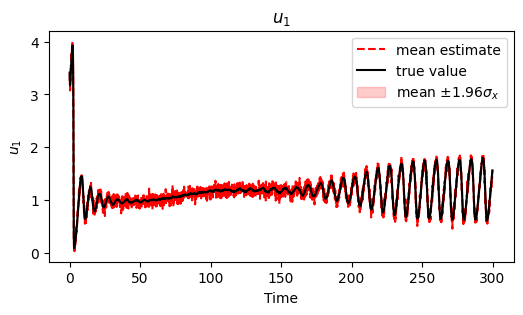

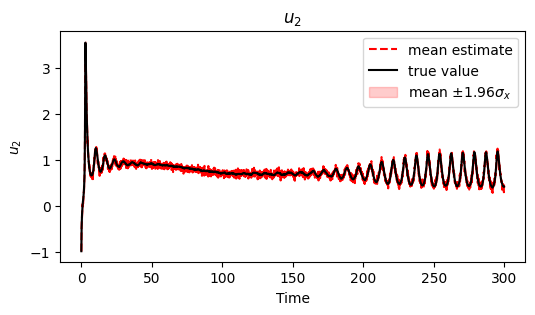

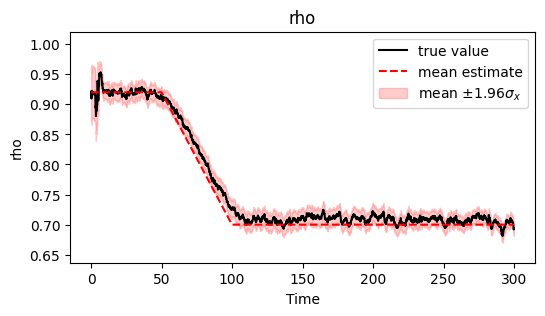

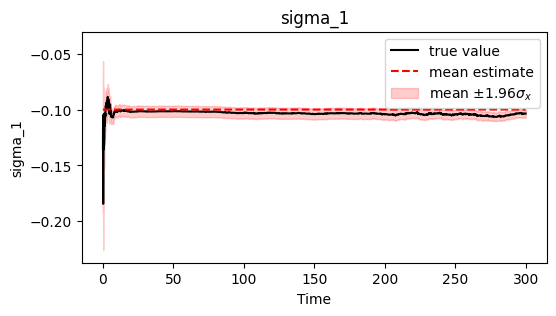

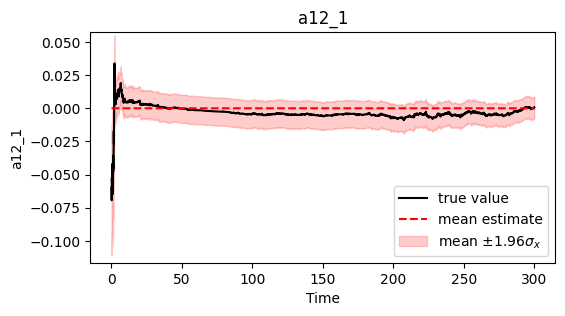

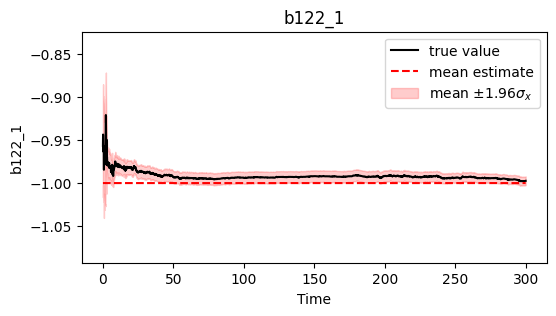

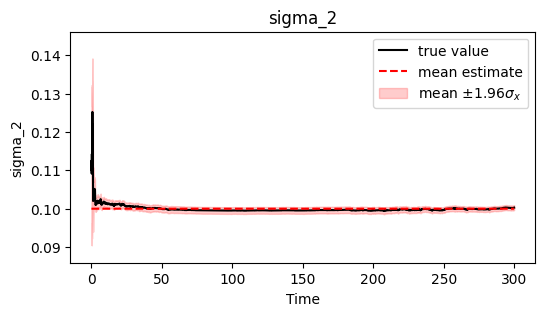

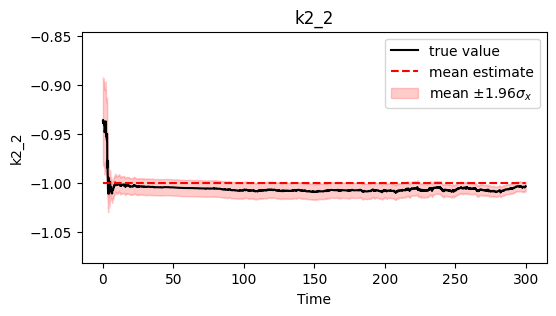

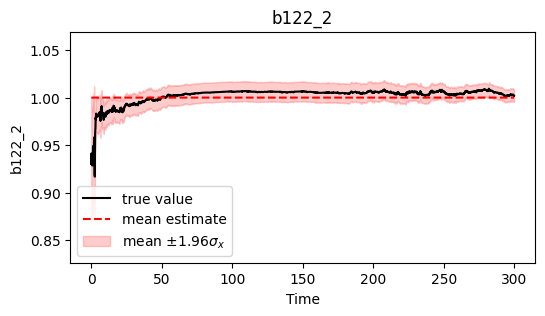

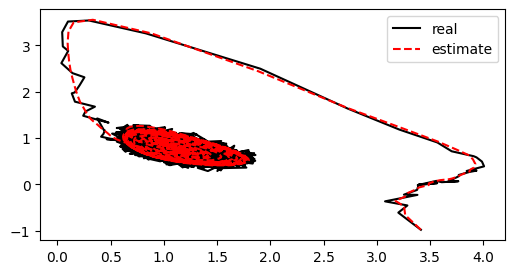

In [13]:
# %%
def plot_outcomes(t_axis, X_data_obs, xhat_taxis, xhat_taxis_piu_sigma, xhat_taxis_meno_sigma, obs_taxis, N_x, N_param, true_coeff, coeff_names):
    variable_names = ['$u_1$', '$u_2$']
    for i1 in np.arange(N_x):
        plt.figure(figsize=[6, 3])
        plt.plot(t_axis[ntsp:ntst], X_data_obs[ntsp:ntst, i1], 'r--', label = 'mean estimate')
        plt.plot(t_axis[ntsp:ntst], xhat_taxis[i1, ntsp:ntst], 'k', label = 'true value')
        plt.fill_between(t_axis[ntsp:ntst], xhat_taxis_piu_sigma[i1, ntsp:ntst], xhat_taxis_meno_sigma[i1, ntsp:ntst], color='red', alpha=0.2, label=f"mean $\\pm 1.96\sigma_x$")
        plt.xlabel('Time')
        plt.ylabel(f'{variable_names[i1]}')
        plt.title(variable_names[i1])
        plt.legend()
        plt.show()

    for i1 in np.arange(N_param):  # Plot linear stiffness/ coupling terms
        plt.figure(figsize=[6, 3])
        plt.plot(t_axis[ntsp + 1:ntst], xhat_taxis[i1 + N_x, ntsp + 1:ntst], 'k', label = 'true value')
        # Step transition for rho
        if i1 == 0:
          rho_start, rho_end, T, T1, T_sweep  = system['rho_start'], system['rho_end'], system['T'], system['T1'], system['T_sweep']
          rho_step = np.piecewise(t,[t < T1, (t >= T1) & (t <= T1 + T_sweep), t > T1 + T_sweep],[rho_start, lambda t: rho_start + (rho_end - rho_start) * (t - T1) / T_sweep, rho_end])
          plt.plot(t_axis[ntsp + 1:ntst], rho_step[ntsp + 1:ntst], 'r--', label = 'mean estimate')
        else:
            plt.plot(t_axis[ntsp + 1:ntst], np.ones(ntst - ntsp - 1) * true_coeff[i1], 'r--',label = 'mean estimate')
        plt.fill_between(t_axis[ntsp + 1:ntst], xhat_taxis_piu_sigma[i1 + N_x, ntsp + 1:ntst], xhat_taxis_meno_sigma[i1 + N_x, ntsp + 1:ntst], color='red', alpha=0.2, label=f"mean $\\pm 1.96\sigma_x$")
        plt.xlabel('Time')
        plt.ylabel(f'{coeff_names[i1]}')
        plt.title(coeff_names[i1])
        y_limits = [np.min([true_coeff[i1], np.min(xhat_taxis_meno_sigma[i1 + N_x, ntsp + 1:ntst])]),
                    np.max([true_coeff[i1], np.max(xhat_taxis_piu_sigma[i1 + N_x, ntsp:ntst])])]
        plt.ylim(y_limits[0] * (1 - np.sign(y_limits[0]) * 0.05), y_limits[1] * (1 + np.sign(y_limits[1]) * 0.05))
        plt.legend()
        plt.show()

    return t_axis[ntsp:ntst], rho_step

# %% plot phase space
def plot_phase_space(t, X_data_obs, xhat_taxis, xhat_taxis_piu_sigma, xhat_taxis_meno_sigma, obs_taxis, N_x, plot_equil, plot_bounds, true_coeff):
    variable_names = ['real', 'estimate']
    plt.figure(figsize=[6, 3])
    plt.plot(X_data_obs[ntsp:ntst, 0], X_data_obs[ntsp:ntst, 1], 'k', label=variable_names[0])
    plt.plot(xhat_taxis[0, ntsp:ntst], xhat_taxis[1, ntsp:ntst], 'r--', label=variable_names[1])
    if plot_bounds:
        plt.plot(xhat_taxis_piu_sigma[0, ntsp:ntst], xhat_taxis_piu_sigma[1, ntsp:ntst], 'k', linestyle='--')
        plt.plot(xhat_taxis_meno_sigma[0, ntsp:ntst], xhat_taxis_meno_sigma[1, ntsp:ntst], 'k', linestyle='--')
    if plot_equil:
        # Note: Estimated equilibrium does not account for the use of two different sigma parameters
        real_equil = [true_coeff[0] / (true_coeff[4] + true_coeff[0] ** 2), true_coeff[0]]
        estimated_equil = [xhat_taxis[N_x, ntst - 1] / (xhat_taxis[N_x + 4, ntst - 1] + xhat_taxis[N_x, ntst - 1] ** 2), xhat_taxis[N_x, ntst - 1]]
        plt.plot(estimated_equil[0], estimated_equil[1], marker='+', markersize=10, color='k', markeredgewidth=3)
        plt.plot(real_equil[0], real_equil[1], marker='+', markersize=10, color='r--', markeredgewidth=3)
    plt.legend()
    plt.show()

    return

ntsp = 0
ntst = Nt_analysis

# %% Plot outcomes
t_axis, rho_step = plot_outcomes(t, X, xhat_taxis, xhat_taxis_piu_sigma, xhat_taxis_meno_sigma, obs_taxis, N_x, N_param, true_coeff, coeff_names)

# %% Plot phase space
ntsp = 0
ntst = int(Nt_analysis)
plot_equil = 0
plot_bounds = 0
plot_phase_space(t, X, xhat_taxis, xhat_taxis_piu_sigma, xhat_taxis_meno_sigma, obs_taxis, N_x, plot_equil, plot_bounds, true_coeff)